In [29]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from strategies.base import Strategy
sns.set()

In [31]:
# Parameters
ticker1 = 'KO'
ticker2 = 'PEP'
start_date = '2020-01-01'
end_date = '2024-12-31'
window = 20
initial_cash = 100_000

In [33]:
df1 = yf.download(ticker1, start = start_date, end = end_date)[['Close']]
df2 = yf.download(ticker2, start = start_date, end = end_date)[['Close']]
df= pd.concat([df1, df2], axis = 1)
df.columns = ['price1', 'price2']
df.dropna(inplace=True)

C:\Users\Alqama\AppData\Local\Temp\ipykernel_14660\905509373.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df1 = yf.download(ticker1, start = start_date, end = end_date)[['Close']]
[*********************100%***********************]  1 of 1 completed
C:\Users\Alqama\AppData\Local\Temp\ipykernel_14660\905509373.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df2 = yf.download(ticker2, start = start_date, end = end_date)[['Close']]
[*********************100%***********************]  1 of 1 completed


In [35]:
# spread and z-score calculation
df['spread'] = df['price1'] - df['price2']
df['mean'] = df['spread'].rolling(window).mean()
df['std'] = df['spread'].rolling(window).std()
df['z_score'] = (df['spread'] - df['mean']) / df['std']

In [37]:
# Signal Generation
df['position'] = 0
df.loc[df['z_score'] > 1, 'position'] = -1    # Short spread: short price1, long price2
df.loc[df['z_score'] < -1, 'position'] = +1   # Long spread: long price1, short price2

In [39]:
# daily returns of the spread (price1 - price2)
df['spread_return'] = df['price1'].pct_change() - df['price2'].pct_change()
df['strategy'] = df['position'].shift(1) * df['spread_return']

In [41]:
# equity curve
df['equity_curve'] = initial_cash * (1 + df['strategy']).cumprod()

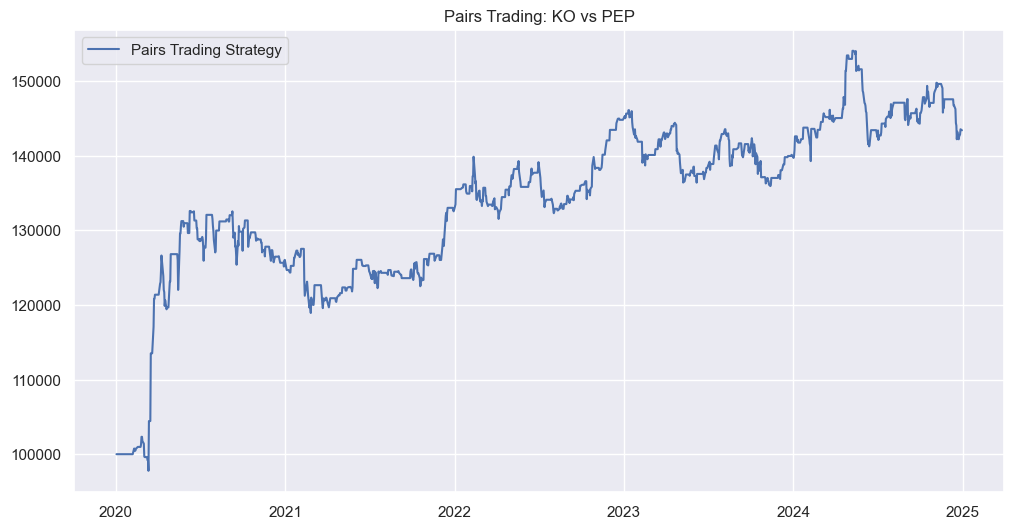

In [43]:
# plot
plt.figure(figsize=(12, 6))
plt.plot(df['equity_curve'], label='Pairs Trading Strategy')
plt.title(f'Pairs Trading: {ticker1} vs {ticker2}')
plt.legend()
plt.show()

In [45]:
class PairsTradingStrategy(Strategy):
    def __init__(self, window=30, z_entry=1.0, z_exit=0.0):
        self.window = window
        self.z_entry = z_entry
        self.z_exit = z_exit

    def generate_signals(self, df1, df2):
        spread = df1['price'] - df2['price']
        mean = spread.rolling(self.window).mean()
        std = spread.rolling(self.window).std()
        z_score = (spread - mean) / std

        position = pd.Series(0, index=df1.index)
        position[z_score > self.z_entry] = -1  # Short spread
        position[z_score < -self.z_entry] = 1  # Long spread
        position[abs(z_score) < self.z_exit] = 0  # Close position

        df = pd.DataFrame({
            'spread': spread,
            'z_score': z_score,
            'position': position,
            'returns': (df1['price'] - df1['price'].shift(1)) - (df2['price'] - df2['price'].shift(1))
        })
        df['strategy'] = df['position'].shift(1) * df['returns']
        df.dropna(inplace=True)
        return df

In [49]:
def backtest_pairs(ticker1, ticker2, start, end, strategy):
    df1 = yf.download(ticker1, start=start, end=end)[['Adj Close']]
    df2 = yf.download(ticker2, start=start, end=end)[['Adj Close']]
    df1.columns = ['price']
    df2.columns = ['price']
    df1.dropna(inplace=True)
    df2.dropna(inplace=True)

    df = strategy.generate_signals(df1, df2)
    df['equity_curve'] = 100_000 * (1 + df['strategy']).cumprod()

In [55]:
def apply_stop_loss(df, stop_loss_pct=0.02):
    equity = [100_000]
    position, entry_price = 0, None
    for i in range(1, len(df)):
        if df['position'].iloc[i] != position:
            position = df['position'].iloc[i]
            entry_price = df['price'].iloc[i]
        price = df['price'].iloc[i]
        if position != 0 and entry_price:
            pnl = (price - entry_price) / entry_price * position
            if pnl < -stop_loss_pct:
                position = 0
        equity.append(equity[-1] * (1 + df['returns'].iloc[i] * position))
    df['equity_curve_sl'] = equity
    return df

In [57]:
def apply_drawdown_limit(df, max_drawdown=0.1):
    eq = 100_000 * (1 + df['strategy']).cumprod()
    peak = eq.cummax()
    dd = (eq - peak) / peak
    df['equity_curve_dd'] = 100_000 * (1 + df['strategy'].where(dd >= -max_drawdown, 0)).cumprod()
    return df

In [59]:
def apply_position_sizing(df, risk_pct=0.02):
    df['scaled_strategy'] = df['position'].shift(1) * df['returns'] * risk_pct
    df['equity_curve_ps'] = 100_000 * (1 + df['scaled_strategy']).cumprod()
    return df

In [61]:
def run_backtest(ticker, strategy, risk_sl=0.02, risk_dd=0.1, risk_ps=0.02):
    df = yf.download(ticker, '2020-01-01', '2024-12-31')[['Adj Close']].copy()
    df.columns = ['price']
    df.dropna(inplace=True)
    df = strategy.generate_signals(df)
    df['returns'] = df['price'].pct_change()
    df['strategy'] = df['position'].shift(1) * df['returns']
    df.dropna(inplace=True)
    df = apply_stop_loss(df, stop_loss_pct=risk_sl)
    df = apply_drawdown_limit(df, max_drawdown=risk_dd)
    df = apply_position_sizing(df, risk_pct=risk_ps)
    return df

In [63]:
strategy = MomentumStrategy(window=50)
df = run_backtest('AAPL', strategy)

plt.figure(figsize=(12, 6))
plt.plot(df['equity_curve_sl'], label='With Stop-Loss')
plt.plot(df['equity_curve_dd'], label='With Drawdown Limit')
plt.plot(df['equity_curve_ps'], label='With Position Sizing')
plt.plot(100_000 * (1 + df['returns']).cumprod(), '--', label='Buy & Hold')
plt.title('AAPL Momentum Backtest with Risk Controls')
plt.legend()
plt.show()

NameError: name 'MomentumStrategy' is not defined